# Creating Directories

In [19]:
%matplotlib inline

In [20]:
from __future__ import division,print_function

import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=180)
from shutil import copyfile, copy, rmtree, move

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential
from keras.layers import Input
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix

import scipy

# Setting Up Data

In [7]:
%cd
%cd nbs
path = "data/dogscatsredux/"

/home/ubuntu
/home/ubuntu/nbs


Start making validation set from training data.

In [54]:
%mkdir data/dogscatsredux/valid

In [55]:
g = glob("data/dogscatsredux/train/*.jpg")
shuf = np.random.permutation(g)
for i in range(2000): copy(shuf[i], path + 'valid')

In [56]:
%ls data/dogscatsredux/train/ | wc -l

25000


In [58]:
%ls data/dogscatsredux/valid/ | wc -l

2000


Make cats and dogs folders for training and validation sets to set up for training. Once done, move all related images into their appropriate folders.

In [59]:
%cd data/dogscatsredux/
%mkdir valid/cats/
%mkdir valid/dogs/
%mkdir train/cats/
%mkdir train/dogs/

/home/ubuntu/nbs/data/dogscatsredux


In [60]:
%mv valid/cat.*.jpg valid/cats/
%mv valid/dog.*.jpg valid/dogs/
%mv train/cat.*.jpg train/cats/
%mv train/dog.*.jpg train/dogs/

In [61]:
%ls valid/cats/ | wc -l
%ls valid/dogs/ | wc -l
%ls train/cats/ | wc -l
%ls train/dogs/ | wc -l

1010
990
12500
12500


# Vgg Model

In [27]:
%cd
%cd nbs
import utils; reload(utils)
import vgg16; reload(vgg16)
from vgg16 import Vgg16

/home/ubuntu
/home/ubuntu/nbs


In [8]:
batch_size = 64
vgg = Vgg16()
batches = vgg.get_batches(path+'train', batch_size = batch_size)
val_batches = vgg.get_batches(path + 'valid', batch_size = batch_size * 2)

Found 25000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [64]:
vgg.finetune(val_batches)
vgg.fit(batches, val_batches, nb_epoch = 3)

Epoch 1/3
25000/25000 [==============================] - 660s - loss: 0.1302 - acc: 0.9654 - val_loss: 0.0525 - val_acc: 0.9820
Epoch 2/3
25000/25000 [==============================] - 661s - loss: 0.0900 - acc: 0.9786 - val_loss: 0.0589 - val_acc: 0.9835
Epoch 3/3
25000/25000 [==============================] - 661s - loss: 0.0998 - acc: 0.9782 - val_loss: 0.0711 - val_acc: 0.9805


In [89]:
%cd
%cd nbs
vgg.model.save_weights('data/dogscatsredux/results/ft5.5')

/home/ubuntu
/home/ubuntu/nbs


# Result Analysis

In [9]:
%cd
%cd nbs
vgg.model.load_weights('data/dogscatsredux/results/ft5.5')

/home/ubuntu
/home/ubuntu/nbs


Testing on our validation dataset.

In [10]:
%cd
%cd nbs/data/dogscatsredux/
val_batches, probs = vgg.test('valid/', batch_size = batch_size)

/home/ubuntu
/home/ubuntu/nbs/data/dogscatsredux
Found 2000 images belonging to 2 classes.


In [22]:
filenames = val_batches.filenames
expected_labels = val_batches.classes

#Round predictions to nearest whole number
our_predictions = probs[:,0]
our_labels = np.round(1-our_predictions)

In [37]:
from keras.preprocessing import image
#Helper function to plot images by index in the validation set 
#Plots is a helper function in utils.py
def plots_idx(idx, titles=None):
    utils.plots([image.load_img('data/dogscatsredux/valid/' + filenames[i]) for i in idx], titles=titles)
    
#Number of images to view for each visualization task
n_view = 4

Predictions -> Correct Labels

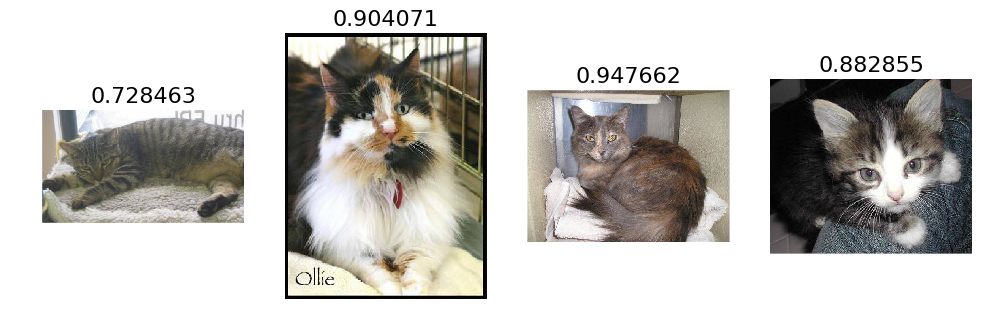

In [54]:
correct = np.where(our_labels==expected_labels)[0]
#print "Found (%d) correct labels" % len(correct)
idx = np.random.permutation(correct)[:n_view]
plots_idx(idx, our_predictions[idx])

Predictions -> Incorrect Labels

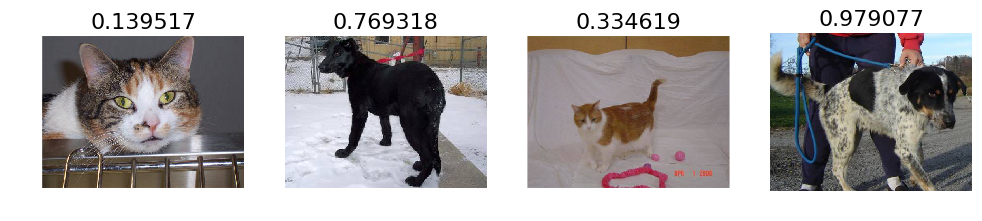

In [57]:
incorrect = np.where(our_labels != expected_labels)[0]
#print "Found %d incorrect labels" % len(incorrect)
idx = np.random.permutation(incorrect)[:n_view]
plots_idx(idx, our_predictions[idx])

Predictions -> Confident they're Cats. They were Cats.

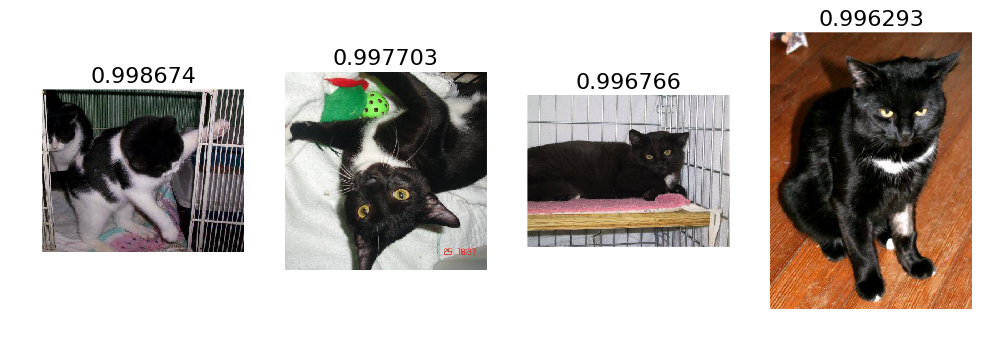

In [58]:
correct_cats = np.where((our_labels==0) & (our_labels==expected_labels))[0]
#print "Found %d confident correct cats labels" % len(correct_cats)
most_correct_cats = np.argsort(our_predictions[correct_cats])[::-1][:n_view]
plots_idx(correct_cats[most_correct_cats], our_predictions[correct_cats][most_correct_cats])

Predictions -> Confident they're Dogs. They were Dogs.

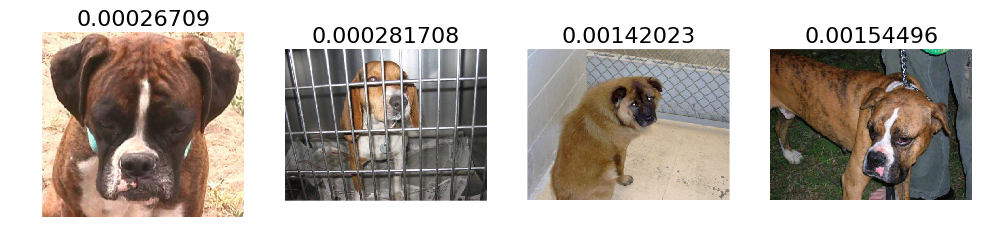

In [59]:
correct_dogs = np.where((our_labels==1) & (our_labels==expected_labels))[0]
#print "Found %d confident correct dogs labels" % len(correct_dogs)
most_correct_dogs = np.argsort(our_predictions[correct_dogs])[:n_view]
plots_idx(correct_dogs[most_correct_dogs], our_predictions[correct_dogs][most_correct_dogs])

Predictions -> Confident they're Cats. They were Dogs.

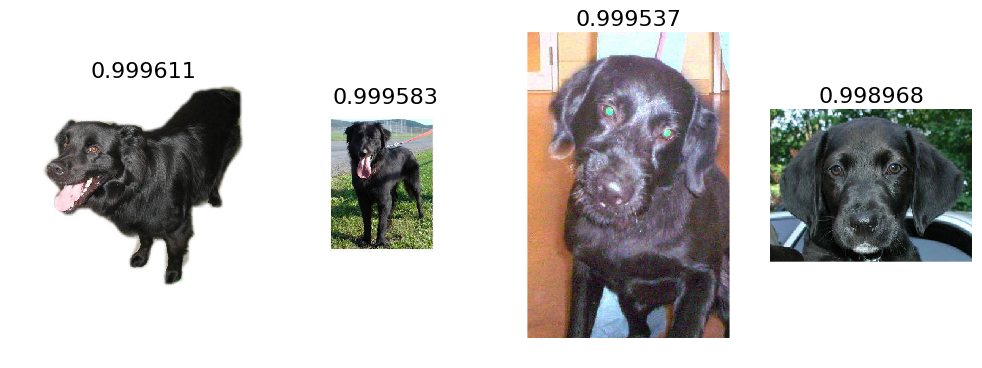

In [60]:
incorrect_cats = np.where((our_labels==0) & (our_labels!=expected_labels))[0]
#print "Found %d incorrect cats" % len(incorrect_cats)
if len(incorrect_cats):
    most_incorrect_cats = np.argsort(our_predictions[incorrect_cats])[::-1][:n_view]
    plots_idx(incorrect_cats[most_incorrect_cats], our_predictions[incorrect_cats][most_incorrect_cats])

Predictions -> Confident they're Dogs. They were Cats.

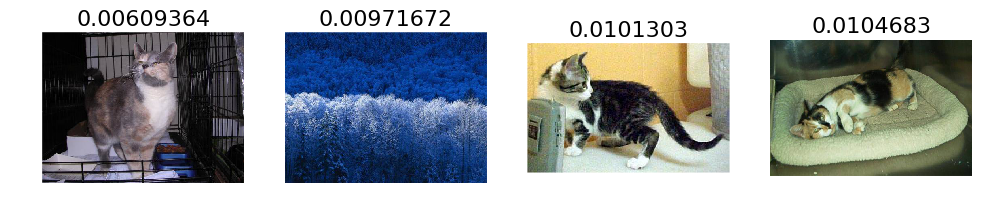

In [61]:
incorrect_dogs = np.where((our_labels==1) & (our_labels!=expected_labels))[0]
#print "Found %d incorrect dogs" % len(incorrect_dogs)
if len(incorrect_dogs):
    most_incorrect_dogs = np.argsort(our_predictions[incorrect_dogs])[:n_view]
    plots_idx(incorrect_dogs[most_incorrect_dogs], our_predictions[incorrect_dogs][most_incorrect_dogs])

Predictions -> Uncertain Labels (Probability close to 0.5)

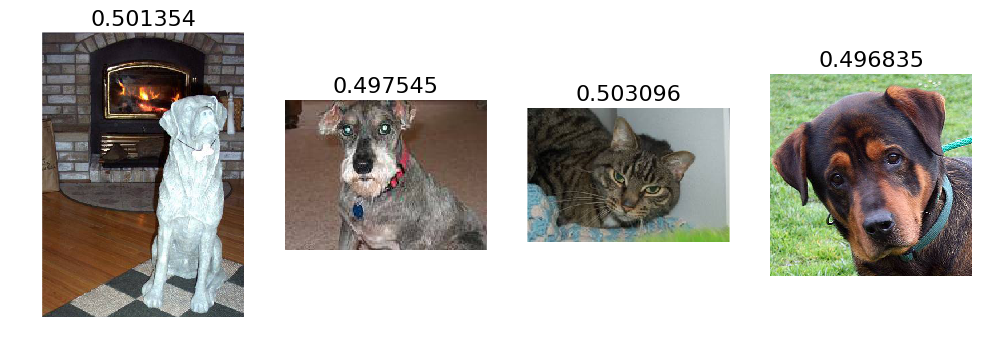

In [62]:
most_uncertain = np.argsort(np.abs(our_predictions-0.5))
plots_idx(most_uncertain[:n_view], our_predictions[most_uncertain])

# Submission to Kaggle

In [2]:
import bcolz
def save_array(fname, arr): c = bcolz.carray(arr, rootdir = fname, mode = 'w'); c.flush()
def load_array(fname): return bcolz.open(fname)[:]

Moving all test images into one folder to make it easier to access the data during testing the Vgg model.

In [29]:
%cd
%cd nbs/data/dogscatsredux/
%mkdir test/unknown/

/home/ubuntu
/home/ubuntu/nbs/data/dogscatsredux


In [30]:
%mv test/*.jpg test/unknown/

In [31]:
%ls test/ | wc -l
%ls test/unknown | wc -l

1
12500


In [ ]:
batch_size = 64
batches, preds = vgg.test('test', batch_size = 64)

Found 12500 images belonging to 1 classes.


INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-2.7.12-64/lock_dir/lock


In [ ]:
filenames = batches.filenames

In [ ]:
save_array("results/test_filenames", filenames)
save_array("results/test_pred", preds)

In [4]:
%cd
%cd nbs/data/dogscatsredux/

/home/ubuntu
/home/ubuntu/nbs/data/dogscatsredux


Making an array with an output as column 1 as the Image filename and column 2 as the prediction based off of 1 for dog, and 0 for cat.

In [5]:
preds = load_array("results/test_pred")
filenames = load_array("results/test_filenames")

In [8]:
isdog = preds[:, 1]
isdog = np.clip(preds[:, 1], .025, .975)
isdog[:5]

array([ 0.025,  0.025,  0.025,  0.025,  0.975], dtype=float32)

In [9]:
ids = [int(f[8:f.find('.')]) for f in filenames]
ids[:5]

[9292, 12026, 9688, 4392, 779]

In [14]:
subm = np.stack([ids, isdog], axis = 1)
subm[:5]

array([[  9.2920e+03,   2.5000e-02],
       [  1.2026e+04,   2.5000e-02],
       [  9.6880e+03,   2.5000e-02],
       [  4.3920e+03,   2.5000e-02],
       [  7.7900e+02,   9.7500e-01]])

In [15]:
%cd
%cd nbs
np.savetxt('data/dogscatsredux/subm98_3.csv', subm, fmt = '%d, %.5f', header = 'id,label', comments = '')
from IPython.display import FileLink
FileLink('data/dogscatsredux/subm98_3.csv')

/home/ubuntu
/home/ubuntu/nbs


/home/ubuntu/nbs/data/dogscatsredux/subm98_3.csv